# Document Similarity
### Using FastText Word Embedding
https://fasttext.cc/docs/en/aligned-vectors.html

In [228]:
# The following parameter set to True means we want to load some data from pickle.
load_from_pickle = True

In [229]:
import warnings
warnings.filterwarnings("ignore")
from gensim.models import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import operator
import re

# import natural language toolkit
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric
from nltk.corpus   import stopwords
from nltk.tokenize import word_tokenize

import string

In [230]:
from modules.library.postgresql import PostgresQL
# # connect to the postgresql database
pg = PostgresQL() 
pg.connect(database="eurlex_environment_only", user="postgres", password="dbpass")

In [231]:
from modules.library.word_models import WordModels

In [232]:
from modules.library.document_similarity import DocumentSimilarity

In [233]:
from modules.library.document_models import DocumentModels

In [234]:
rand_seed = 4
k = 20

In [235]:
if load_from_pickle:
    with open('variables.pkl', "rb") as f:
        e = pickle.load(f)

In [236]:
if load_from_pickle:
    law_word_vectors = e[0]
    documents = e[1]
    documents_stripped = e[2]
    we = e[3]
    non_null = e[4]
    non_null_id = e[5]
    docembeddings_transformed = e[6]
    all_descriptors = e[7]
    descriptors_embedding = e[8] 
    descriptors_embedding_transformed = e[9]
    indices = e[10]
    indices2 = e[11]
    law_doc_vectors = e[12]
    law_doc_vectors_transformed = e[13]
    law_indices = e[14]
    subtracted_emb = e[15]
    subtracted_emb_transformed = e[16]
    subtracted_indices = e[17]
    u = e[18]
    s = e[19]
    vh = e[20]

Importing pre-trained FastText word embeddings of English words. We chose to use aligned word vectors, which will enable us to provide cross-lingual support.

In [237]:
# wiki_en_align = '../data/fasttext/wiki.en.align.vec'
# wiki_en_model = KeyedVectors.load_word2vec_format(wiki_en_align)

In [238]:
# with open("wwe.pkl", "wb") as f:
#     pickle.dump(wiki_en_model, f, protocol=-1)

In [239]:
with open("wwe.pkl", "rb") as f:
    wiki_en_model = pickle.load(f)

Importing another module trained on legal documents

In [240]:
if not load_from_pickle:
    law_word_vectors = KeyedVectors.load_word2vec_format('../data/Law2Vec/Law2Vec.200d.txt', binary=False)

## Processing Data

Preparing list of stopwords (words that appear regularly in the vocabulary and are not so significant for a specific document).

In [241]:
# prepare stopword list
stop_words = stopwords.words('english') + list(string.punctuation)

Tokenize the text of the document - remove stopwords and punctuation and split it in words. We also count the occurance of words in the document and order them by number of occurances decreasingly.

In [242]:
# %load -s tokenize document_embeddings.py
def tokenize(text, stop_words):
    """Tokenizes and removes stopwords from the document"""

    def customized_strip(s):
        s = s.replace('"', '')
        s = s.replace("'", '')
        s = s.replace('“', '')
        s = s.replace('”', '')
        s = s.replace("\r", ' ').replace("\xa0", ' ')
        s = re.sub('https?:\/\/[^\s]+', ' ', s)
        s = re.sub('[\d]+', ' ', s)
        s = re.sub('[\s]+', ' ', s)
        s = strip_punctuation(s)
        return s
        
    # Strip the text of comments, urls, numbers and newline
    stripped_text = customized_strip(text)

    # Strip punctuation and make everything lowercase
    custom_filters = [lambda x: x.lower(), strip_punctuation]
    tokens = preprocess_string(stripped_text, custom_filters)
    filtered = [w for w in tokens if not w in stop_words]

    #return filtered
    # get the most frequent words in the document
    count = { }
    for word in filtered:
        if word not in count:
            count[word] = 0
        count[word] += 1

    word_sorted = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
    return word_sorted


In [243]:
# %load -s euclid_similarity document_embeddings.py
def euclid_similarity(emb1, emb2):
    """Calculate the euclid similarity between two embeddings"""
    return np.linalg.norm(emb1 - emb2)


## Document embeddings

In this section we write several document embeddings. They will be used later to find the optimal way to represent our data.

Save all documents of EUR-Lex database into a variable 'documents'.

In [244]:
if not load_from_pickle:
    documents = pg.execute("""
        SELECT * FROM documents;
    """)

In [245]:
if not load_from_pickle:
    documents = [doc for doc in documents if len(doc['document_text']) > 0]

In [246]:
N = len(documents)
print(N)

76261


In [247]:
list_of_tokens = tokenize(documents[0]['document_text'], stop_words)
token, nr_token = list_of_tokens[0]
token

'regulation'

In [248]:
if not load_from_pickle:
    documents_stripped = [" ".join([token for token, nr_token in tokenize(doc['document_text'], stop_words)]) for 
                          doc in documents]

In [249]:
documents_stripped[51]

'eff eur axis fishing financial period year commission implementation member cessation fisheries eu total public states aquaculture also measures commitments national per may european support permanent fleets operations report temporary july increase million operation processing convergence economic number committed scrapping regulation fleet funding information vessels development – art regions non priority projects data terms annual table areas fuel article increased local study coastal private fund technical investments two part billion average contribution expenditure small assessment payments amounts significant compared shows amount including show jobs scale cost sector main assistance farnet time end amounted supported however order portugal evaluation increasing authorities less leverage use coordination funds board selectivity sustainable execution council points interim december relative acceleration programmes percentage one last fish necessary ensure used ms capacity anothe

### Document embedding via word embeddings

We will first implement a simple version of document embedding that relies on the fact, that we already have a basis of word embeddings. Document embedding will be defined as an average of word embeddings of words that appear in 'document_text'.

In [250]:
# %load -s simple_docemb document_embeddings.py
def simple_docemb(text, stopwords, wv):
    """Creates a document embedding as the average of corresponding token embeddings"""
    embedding = np.zeros(wv.vector_size, dtype=np.float32)

    if text is None:
        return embedding

    word_sorted = tokenize(text, stopwords)
    norm = 0
    for token, a in word_sorted:
        # sum all tokens embeddings of the vector
        if token in wv.vocab.keys():
            embedding += a*wv[token]
            norm += a
    # return the normalized embedding; if not zero
    return embedding if norm == 0 else embedding / norm


We embed documents in our database. As shown before the total number of documents in the database is more than 100.000, so we limit ourselves and embed only 15.000.

In [251]:
# %load -s dataset_embedding document_embeddings.py
def dataset_embedding(dataset, stopwords, wv, document_embedding):
    """Creates the dataset embeddings given a document_embedding function"""

    embeddings = np.zeros((len(dataset), wv.vector_size), dtype=np.float32)
    for id, document in enumerate(dataset):
        text = document['document_text']
        embeddings[id,:] = document_embedding(text, stopwords, wv)
        if id % 5000 == 0:
            print('Processed document number = {}'.format(id))
    return embeddings


In [252]:
if not load_from_pickle:
    limit = N
    we = dataset_embedding(documents[:limit], stop_words, wiki_en_model, simple_docemb)

We filter through them and pick only the ones with non-zero embeddings (the ones with 'document_text' differet then 'None').

In [253]:
if not load_from_pickle:
    non_null = [x for x in we if np.linalg.norm(x) != 0]
    non_null_id = [i for i in range(len(we)) if np.linalg.norm(we[i]) != 0]
len(non_null)

76261

In order to plot the embeddings we need to reduce the dimension to 2 (or 3). We use the TSNE method and plot the embeddings.

In [254]:
if not load_from_pickle:
    docembeddings_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(non_null)

In [255]:
type(docembeddings_transformed)

numpy.ndarray

In [256]:
# XX = docembeddings_transformed[:4000, :]
# XX.shape

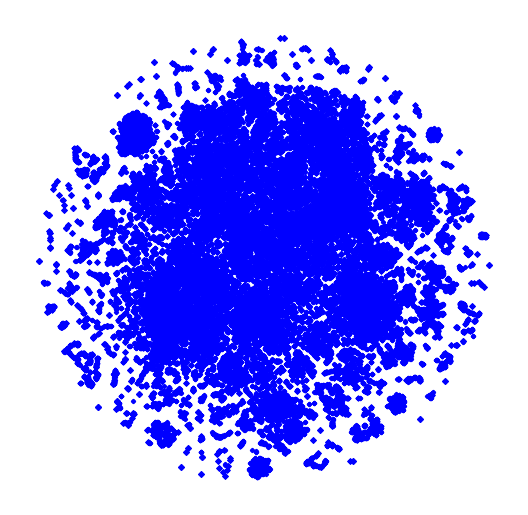

In [257]:
# get the (x, y) coordinates
x, y = docembeddings_transformed.transpose()[0], docembeddings_transformed.transpose()[1]
# draw the points into the landscape
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
# show the image
plt.axis('off')
plt.show()

### Document embedding via document descriptors

We can consider document descriptors to be some kind of summary of the document. We will use them to define a document embedding as the average of word embeddings of words that appear in document descriptors.

Let's first see how to access descriptors of the document with CELEX number 22015P0513(01).

In [258]:
descriptors = pg.execute("""
    SELECT * FROM document_descriptors WHERE document_celex_num='22015P0513(01)';
""")

In [259]:
print(descriptors)
#print(descriptors[0]['descriptor_name'])

[{'document_celex_num': '22015P0513(01)', 'descriptor_name': 'Africa'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'deforestation'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'Democratic Republic of the Congo'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'disease prevention'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'economic cooperation'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'international cooperation'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'nature reserve'}]


We gather them in a dictionary 'all_descriptors', where keys are CELEX numbers of documents and values are lists of their descriptors.

In [260]:
# %load -s get_descriptors document_embeddings.py
def get_descriptors(indices, documents=documents):
    """Returns a dictionary of descriptors for specified documents"""

    # The function returns dictionary 'descriptors' where keys are CELEX numbers of documents and values are descriptors
    # that correspond to appropriate document
    descriptors = {}

    for i in indices:
        celex = documents[i]['document_celex_num']
        doc_descriptors = pg.execute("""
            SELECT * FROM document_descriptors WHERE document_celex_num='{}';
            """.format(celex))
        for descriptor_instance in doc_descriptors:
            if celex not in descriptors:
                descriptors[celex] = [descriptor_instance['descriptor_name']]
            else:
                descriptors[celex].append(descriptor_instance['descriptor_name'])
    return descriptors


In [261]:
if not load_from_pickle:
    all_descriptors = get_descriptors([i for i in range(N)])

We define new document embedding, run it on all documents and save it in variable 'descriptor_embedding'. Further, we reduce the dimension of the embedding and plot it.

In [262]:
# %load -s descemb document_embeddings.py
def descemb(documents, descriptors=all_descriptors, wv=wiki_en_model):
    """Given a dictionary of documents with their descriptors, returns document embeddings based on the descriptors."""

    embedding = np.zeros((len(documents), wv.vector_size), dtype=np.float32)
    #go through documents
    for id, doc in enumerate(documents):
        celex = doc['document_celex_num']
        doc_descriptors = descriptors[celex]
        doc_desctext = " ".join(doc_descriptors)
        embedding[id, :] = simple_docemb(doc_desctext, " ", wv)
    return embedding


In [263]:
if not load_from_pickle:
    descriptors_embedding = descemb(documents)
    descriptors_embedding_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(descriptors_embedding)

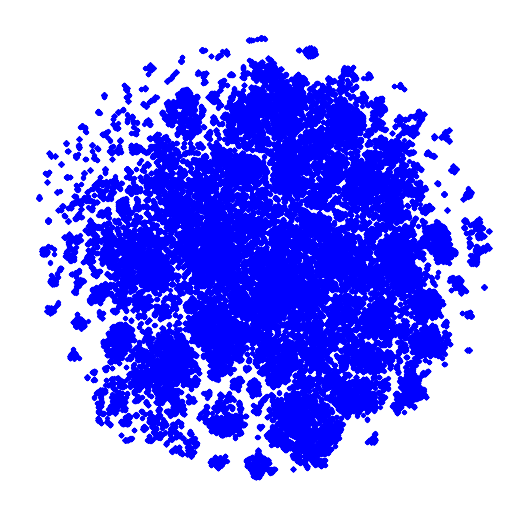

In [264]:
x, y = descriptors_embedding_transformed.transpose()[0], descriptors_embedding_transformed.transpose()[1]
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
plt.axis('off')
plt.show()

### Combined document embedding

We define a new document embedding as a linear combination of already defined ones. After reducing the dimension, we plot it.

In [265]:
# %load -s combemb document_embeddings.py
def combemb(document_embeddings, descriptor_embeddings, alpha):
    """Combines the two embeddings as a linear combination"""
    return alpha*document_embeddings + (1-alpha)*descriptor_embeddings


### Similarity of documents

In this section we will pick a specific document and find others that are most similar to it. We will use methotds we already used for word analysis and more.

We start by picking a document. We'll try to find similar ones.

In [266]:
doc_index = 2 # 14764  #1145
doc_embedded = we[doc_index]
documents[doc_index]

{'document_id': 54624,
 'document_celex_num': '52013DC0319',
 'document_title': 'COMMUNICATION FROM THE COMMISSION TO THE COUNCIL concerning a consultation on Fishing Opportunities for 2014',
 'document_author': 'European Commission',
 'document_form': 'Communication',
 'document_date': datetime.date(2013, 5, 30),
 'document_text': '|52013DC0319COMMUNICATION FROM THE COMMISSION TO THE COUNCIL concerning a consultation on Fishing Opportunities for 2014 /* COM/2013/0319 final */COMMUNICATION FROM THE COMMISSION TOTHE COUNCILconcerning a consultation on FishingOpportunities for 20141.\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 IntroductionThis document sets out the initialintentions of the European Commission concerning the fixing of total allowablecatches (TACs) and effort levels in European waters and for European fishers in2014. Member States and Regional Advisory Councils (RACs) are invited toprovide their views to the Commission for consideration before a final decisionis taken on the C

In [267]:
# %load -s kNN document_embeddings.py
def kNN(embedding, k, de, similarity):
    """Get the k nearest neighbors of a particular document"""

    # calculate the similarities and revert it
    sims = [similarity(embedding, d) for d in de]

    # sort and get the corresponding indices
    indices = []
    for c, index in enumerate(np.argsort(sims)):
        if c == k:
            break
        indices.append(index)

    # return indices of the neighbors
    return indices


We find $k$ documents whose document embeddings are closest to the chosen document. We save their document embeddings in 'doc_neighbors', their distances form chosen document's document embedding in 'doc_distances' and their indices in 'indices'.

In [268]:
if not load_from_pickle:
    indices = kNN(doc_embedded, k, we, similarity=euclid_similarity)

In [269]:
print(indices)

[2, 75297, 74464, 983, 3164, 2464, 69664, 3658, 2776, 70361, 4609, 72268, 1257, 71320, 75607, 4069, 4552, 73883, 71876, 4569]


In [270]:
for i in indices[:5]:
    d = documents[i]
    print(d['document_title'])
    print(' ')

COMMUNICATION FROM THE COMMISSION TO THE COUNCIL concerning a consultation on Fishing Opportunities for 2014
 
COMMUNICATION FROM THE COMMISSION TO THE COUNCIL concerning a consultation on Fishing Opportunities for 2013
 
COMMUNICATION FROM THE COMMISSION concerning a consultation on Fishing Opportunities   COMMUNICATION FROM THE COMMISSION concerning a consultation on Fishing Opportunities
 
COMMUNICATION FROM THE COMMISSION TO THE EUROPEAN PARLIAMENT AND THE COUNCIL Concerning a consultation on Fishing Opportunities for 2015 under the Common Fisheries Policy
 
COMMUNICATION FROM THE COMMISSION on the State of Play of the Common Fisheries Policy and Consultation on the Fishing Opportunities for 2018
 


In [271]:
def plot_neighbors(emb, indices):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
    
    x, y = emb.transpose()[0], emb.transpose()[1]
    ax.scatter(x, y, 2, marker='x', c='b')
    
    temp = emb[indices,:]
    x, y = temp.transpose()[0], temp.transpose()[1]
    ax.scatter(x, y, 10, marker='o', c='r')

    plt.axis('off')
    plt.show()
    return None

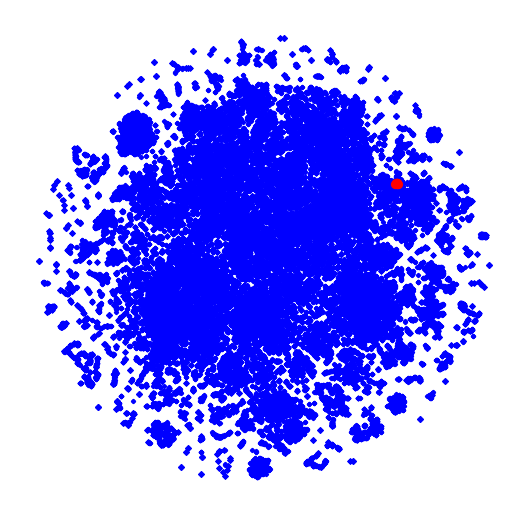

In [272]:
plot_neighbors(docembeddings_transformed, indices[:10])

In [273]:
focus_desc_embedding = descriptors_embedding[doc_index]
if not load_from_pickle:
    indices2 = kNN(focus_desc_embedding, k, de=descriptors_embedding, similarity=euclid_similarity)

In [274]:
for i in indices2[:5]:
    print(documents[i]['document_title'])
    print(' ')

COMMUNICATION FROM THE COMMISSION TO THE COUNCIL concerning a consultation on Fishing Opportunities for 2014
 
Information communicated by Member States regarding closure of fisheries
 
Proposal for a COUNCIL REGULATION amending Regulations (EU) No 43/2012 and (EU) No 44/2012 as regards the protection of the species "giant manta ray" and certain fishing opportunities
 
Corrigendum to Council Regulation (EU) No 43/2012 of 17 January 2012 fixing for 2012 the fishing opportunities available to EU vessels for certain fish stocks and groups of fish stocks which are not subject to international negotiations or agreements ( OJ L 25, 27.1.2012 )
 
Council Regulation (EU) No 43/2012 of 17 January 2012 fixing for 2012 the fishing opportunities available to EU vessels for certain fish stocks and groups of fish stocks which are not subject to international negotiations or agreements
 


In [275]:
limit = N
if not load_from_pickle:
    law_doc_vectors = dataset_embedding(documents[:limit], stop_words, law_word_vectors, simple_docemb)

In [276]:
if not load_from_pickle:
    law_doc_vectors_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(law_doc_vectors)

In [277]:
law_focus_docemb = law_doc_vectors_transformed[doc_index]
if not load_from_pickle:
    law_indices = kNN(law_focus_docemb, k, law_doc_vectors_transformed, similarity=euclid_similarity)

In [278]:
for i in law_indices:
    print(documents[i]['document_title'])
    print(' ')

COMMUNICATION FROM THE COMMISSION TO THE COUNCIL concerning a consultation on Fishing Opportunities for 2014
 
COMMUNICATION FROM THE COMMISSION TO THE EUROPEAN PARLIAMENT AND THE COUNCIL Concerning a consultation on Fishing Opportunities for 2015 under the Common Fisheries Policy
 
COMMUNICATION FROM THE COMMISSION on the State of Play of the Common Fisheries Policy and Consultation on the Fishing Opportunities for 2018
 
COMMUNICATION FROM THE COMMISSION TO THE EUROPEAN PARLIAMENT AND THE COUNCIL Consultation on the fishing opportunities for 2017 under the Common Fisheries Policy
 
COMMISSION STAFF WORKING DOCUMENT Accompanying the document COMMUNICATION FROM THE COMMISSION on the State of Play of the Common Fisheries Policy and Consultation on the Fishing Opportunities for 2019
 
COMMISSION STAFF WORKING DOCUMENT Accompanying the document COMMUNICATION FROM THE COMMISSION on the State of Play of the Common Fisheries Policy and Consultation on the Fishing Opportunities for 2018
 
COM

### Word Movers Distance

In this section we will try to introduce a promising metric for measuring document similarity: Word Movers Distance. It is implemented in gensim library as a function "wmdistance".

First let's pick two documents and compute WMD between them.

In [279]:
index1 = 15
index2 = 3996
doc1 = documents[index1]['document_text']
doc2 = documents[index2]['document_text']

In [280]:
wiki_en_model.wmdistance(doc1, doc2)

0.05484787726248859

Since WMD is very expensive to compute, we will use it on reduced set of closest neighbors. Let's focuse on 'doc1', find a larger set of neighbouring documents and find the k closest neighbors according to WMD.

In [281]:
candidates_ids = kNN(descriptors_embedding_transformed[index1], 100, descriptors_embedding_transformed, euclid_similarity)

In [282]:
texts = [documents_stripped[i] for i in candidates_ids]
WMDids = kNN(texts[0], 10, texts, wiki_en_model.wmdistance)

In [283]:
print(WMDids)

[0, 32, 29, 23, 58, 85, 74, 61, 60, 90]


In [284]:
print([candidates_ids[i] for i in WMDids])

[15, 3265, 71860, 69951, 70355, 72868, 66705, 4066, 4067, 60820]


Because WMD distance is very expensive, we want to check, if it makes any sense to even use it. We can choose different embeddings in which to find most similar documents and limit our search to those. For every embedding we find 50, 100, 500 and 1000 nearest neighbors to the chosen document and run our kNN function again for k=10, but this time we use WMD distance.

We plot the results. The ten nearest neigbors are colored with different colors, depending on how many documents we limited our search on. Documents found after limiting ourselves to 50 documents are colored red, 100 green, 500 yellow and 1000 violet.

In [285]:
def compare_results_WMD(id1=index1, emb=XX):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
    x, y = emb.transpose()[0], emb.transpose()[1]
    ax.scatter(x,  y,  2, marker='x', c='b') 
    colors = {50: 'r', 100: 'g', 500: 'y', 1000: 'm'}
    
    for k in [50, 100, 500, 1000]:
        candidates_ids = kNN(emb[id1], k, emb, euclid_similarity)
        texts = [documents_stripped[i] for i in candidates_ids]
        WMDids = kNN(texts[0], 10, texts, wiki_en_model.wmdistance)
        WMDids = [candidates_ids[i] for i in WMDids]
        temp = emb[WMDids, :]
        x, y = temp.transpose()[0], temp.transpose()[1]
        ax.scatter(x, y, 10, marker='o', c=colors[k])
        
    plt.axis('off')
    plt.show()
    
    return None

Using document embedding by average.

In [286]:
# compare_results_WMD()

Using document embedding by descriptors.

In [287]:
# compare_results_WMD(emb=descriptors_embedding_transformed)

Using combined document embedding where each embedding contributes $\alpha = 0.5$.

In [288]:
# compare_results_WMD(emb=combemb(docembeddings_transformed[:4000,:], descriptors_embedding_transformed, 0.5))

We see that in the case of combined embedding results of our search for nearest documents differ the least depending on the limit of documents we set. This suggests that using combined embedding might be profitable and might produce the best results.

Let's test our hypothesis on other examples.

In [289]:
from random import randint
id1 = randint(0, 4000)

In [290]:
# compare_results_WMD(id1=id1)

In [291]:
# compare_results_WMD(id1=id1,emb=descriptors_embedding_transformed)

In [292]:
# compare_results_WMD(id1=id1, emb=combemb(docembeddings_transformed[:4000,:], descriptors_embedding_transformed, 0.5))

## Training word embedding model

The library ' gensim' enables us to train our own word-embedding model based on pretrained FastText model. We use all the text from all our documents and use the model to perform analysis of documents and their similarity.

We trained our model seperately in order to avoid running expensive code with every run of the notebook. The training is done in the following way:

```python
from gensim.models import FastText

trained_model = FastText(size=4, window=3, min_count=1)
trained_model.build_vocab(sentences=documents_stripped)
trained_model.train(sentences=documents_stripped, total_examples=len(documents_stripped), epochs=10)
```

The model is saved and available in this GitHub repository at [this link](https://github.com/ZivaUrbancic/enviroLENS/tree/master/word-embeddings/data/fasttext).

In [293]:
# from gensim.models import FastText
# path_tm = '../data/fasttext/trained_model.vec'
# trained_model = FastText.load(path_tm)

In [294]:
# trained_model.wv.vector_size

In [295]:
# trained_model.wv.vectors.shape

In [296]:
# wiki_en_model.wv.vectors.shape

In [297]:
# limit = 15000
# # limit = 50
# we_trained = dataset_embedding(documents[:limit], stop_words, trained_model.wv, simple_docemb)

In [298]:
# trained_docemb_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(we_trained[:4000,:])

In [299]:
# # get the (x, y) coordinates
# x, y = trained_docemb_transformed.transpose()[0], trained_docemb_transformed.transpose()[1]
# # draw the points into the landscape
# fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
# ax.scatter(x,  y,  2, marker='x', c='b')
# # show the image
# plt.axis('off')
# plt.show()

In [300]:
# tr_indices = kNN(trained_docemb_transformed[doc_index], k, trained_docemb_transformed, euclid_similarity)

In [301]:
# plot_neighbors(trained_docemb_transformed, tr_indices)

Let's plot the nearest neighbors we got from embedding the documents as average of Word2Vec vectors of words and then do the same with the nearest neighbors in embedding based on embedding of document descriptors.

In [302]:
# plot_neighbors(trained_docemb_transformed, indices)

In [303]:
# plot_neighbors(trained_docemb_transformed, indices2)

In [304]:
# compare_results_WMD(emb=trained_docemb_transformed, metric=trained_model.wmdistance)

We managed to get different lists of k nearest neighbors for different embeddings. A measure of how well they perform might be Word Movers Distance. Let's compute it for all elements in those lists.

In [305]:
# texts = [documents_stripped[i] for i in indices]
# dist1 = [wiki_en_model.wmdistance(t, texts[0]) for t in texts]
# av1 = sum(dist1)/len(dist1)

# lengths1 = [len(documents_stripped[i].split(' ')) for i in indices]
# print(lengths1)

In [306]:
# texts = [documents_stripped[i] for i in indices2]
# dist2 = [wiki_en_model.wmdistance(t, texts[0]) for t in texts]
# av2 = sum(dist2)/len(dist2)

# lengths2 = [len(documents_stripped[i].split(' ')) for i in indices2]
# print(lengths2)

In [307]:
# texts = [documents_stripped[i] for i in law_indices]
# dist3 = [wiki_en_model.wmdistance(t, texts[0]) for t in texts]
# av3 = sum(dist3)/len(dist3)


# lengths3 = [len(documents_stripped[i].split(' ')) for i in law_indices]
# print(lengths3)

In [308]:
# print("Word Movers Distances of kNN for simple document embedding: {}".format(["%.2f"%i for i in dist1]))
# print("Average: {}".format("%.2f" % av1))
# print(" ")
# print("Word Movers Distances of kNN for descriptor embedding: {}".format(["%.2f"%i for i in dist2]))
# print("Average: {}".format("%.2f" % av2))
# print(" ")
# print("Word Movers Distances of kNN for document embedding using Law2Vec: {}".format(["%.2f"%i for i in dist3]))
# print("Average: {}".format("%.2f" % av3))

In [309]:
def compare_distances(document_id, k):
    indices =  kNN(XX[document_id], k, XX, euclid_similarity)
    indices2 = kNN(descriptors_embedding_transformed[document_id], k, 
                   descriptors_embedding_transformed, euclid_similarity)
    indices3 = kNN(law_doc_vectors_transformed[document_id], k, law_doc_vectors_transformed, euclid_similarity)
    I = [indices, indices2, indices3]
    av = [0, 0, 0]
    for i in range(3):
        texts = [documents_stripped[j] for j in I[i]]
        dist = [wiki_en_model.wmdistance(t, texts[0]) for t in texts]
        # dist = [euclid_similarity(document_id, j) for j in I[i]]
        av[i] = sum(dist)/len(dist)
    return av

In [310]:
# averages = [0, 0, 0]
# for i in range(500):
#     c = compare_distances(i, 10)
#     averages = [averages[j] + c[j] for j in range(3)]
# print([i/500 for i in averages])

# Subtraction of Projection on First Singular Vector

In [311]:
if not load_from_pickle:
    u, s, vh = np.linalg.svd(we, full_matrices=True)

In [312]:
first_singular_vector = vh[0, :]
if not load_from_pickle:
    subtracted_emb = np.zeros(we.shape)

In [313]:
if not load_from_pickle:
    for i in range(len(we)):
        temp = np.matmul(we[i,:], first_singular_vector.transpose())
        subtracted_emb[i, :] = we[i, :] - temp*first_singular_vector

In [314]:
if not load_from_pickle:
    subtracted_emb_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(subtracted_emb)

In [315]:
if not load_from_pickle:
    subtracted_indices = kNN(subtracted_emb[doc_index, :], k, subtracted_emb, similarity=euclid_similarity)

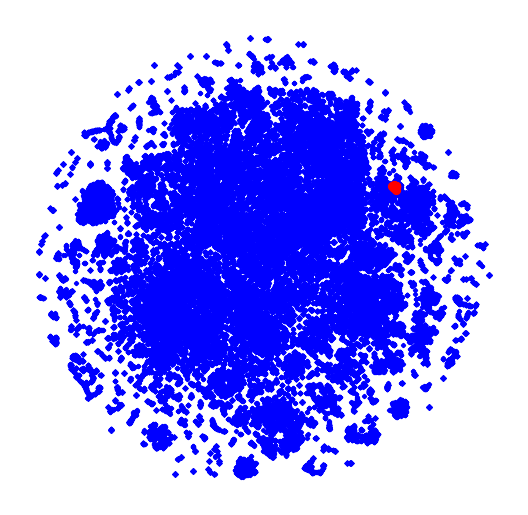

In [316]:
plot_neighbors(subtracted_emb_transformed, indices)

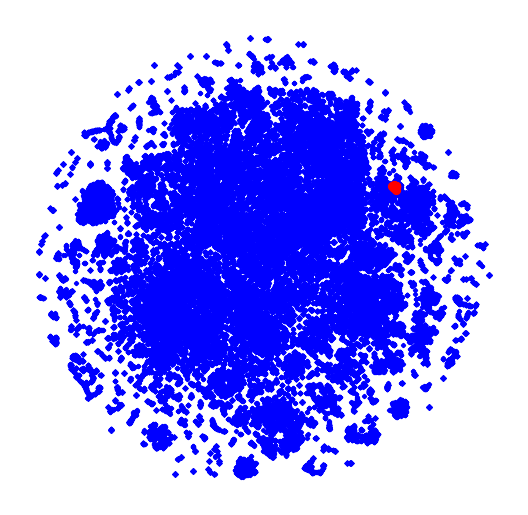

In [317]:
plot_neighbors(subtracted_emb_transformed, subtracted_indices)

## Dropping the variables in a pickle file

In [318]:
dump_to_pickle = False
if dump_to_pickle:
    with open("variables.pkl", "wb") as f:
        pickle.dump([law_word_vectors, documents, documents_stripped, we, non_null, non_null_id, docembeddings_transformed, 
                     all_descriptors, descriptors_embedding, descriptors_embedding_transformed, indices, indices2, 
                     law_doc_vectors, law_doc_vectors_transformed, law_indices, subtracted_emb, subtracted_emb_transformed, 
                     subtracted_indices, u, s, vh], f, protocol=-1)